# Using custom HTML templates

In [1]:
import tslumen
import pandas as pd
import os

In [2]:
# patch it
_read_csv = pd.read_csv
pd.read_csv = lambda fpath, *args, **kwargs: _read_csv(fpath.split('/')[-1], *args, **kwargs)

In [3]:
df = pd.read_csv(
    'https://datahub.io/core/gdp/r/gdp.csv', 
    parse_dates=[2], 
    date_parser=lambda dt: pd.to_datetime(f'{dt}-12-31'),
)
df = df[df['Country Code'].isin(['WLD', 'EUU', 'USA', 'HIC', 'MIC', 'LIC'])]\
    .set_index(['Year', 'Country Code'])['Value'].unstack(1)

pr = tslumen.DefaultProfiler().profile(df)

Profiling:   0%|          | 0/312 [00:00<?, ?it/s]

## Customizing a single Section

HTML generation is performed with the help of [Jinja](https://palletsprojects.com/p/jinja/). All templates are included in the package but can be easily overriden simply by creating the custom version locally. The way it works is first it tries to find the template in some pre-defined local directories, defaulting to the packaged ones if a local version is not found.

In [4]:
tslumen.report.html.base.JINJA_FILE_SEARCHPATHS

['./tslumen/templates/html',
 './templates/html',
 './html',
 '~/.tslumen/templates/html',
 '~/.tslumen/html']

Above are the directories where `tslumen` searches for the templates, in order of precedence.

Let's start by generating the pre-canned *Features* section and then create our own HTML template.


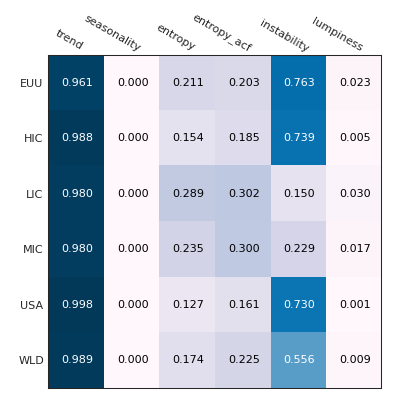
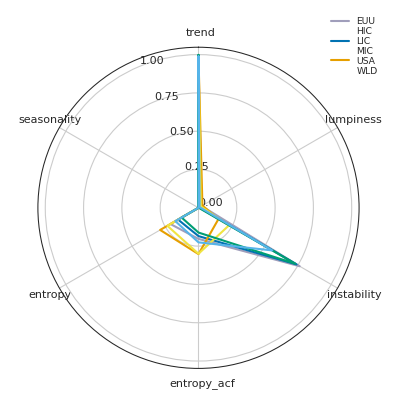

In [5]:
sf = tslumen.report.html.sections.SectionTSFeatures(pr, {}, df)
sf

In [6]:
for attr in dir(sf):
    if not attr.startswith('_'):
        print(f'{attr:12s}', type(getattr(sf, attr)))

df_fts       <class 'pandas.core.frame.DataFrame'>
html         <class 'str'>
html_page    <class 'str'>
plot_heat    <class 'tslumen.plot.static.comparison.Heatmap'>
plot_radar   <class 'tslumen.plot.static.comparison.Radar'>


These are the class attributes we can use in our Jinja template. Obviously for an even more advanced customization you might want to create your own section and report classes.

In [7]:
os.makedirs('./templates/html', exist_ok=True)
with open('./templates/html/SectionTSFeatures.html', 'w') as fp:
    fp.write('''\
{% from '_macros.html' import render_dataframe %}
<h1>My Custom SectionTSFeatures</h1>
{{ render_dataframe('FTS', obj.df_fts) }}
''')

In [8]:
tslumen.report.html.sections.SectionTSFeatures(pr, {}, df)

As you may have noticed, the template makes use of a macro defined elsewhere. Without going into the details of Jinja's templating engine, there is a hierarchical structure implied in tslumen's templates, as well as some useful filters and macros. Refer to the source code for more details.

If we render the full report, the *Features* sections will now look different.

Rendering TimeSeries section:   0%|          | 0/6 [00:00<?, ?it/s]

Rendering remaining sections:   0%|          | 0/3 [00:00<?, ?it/s]


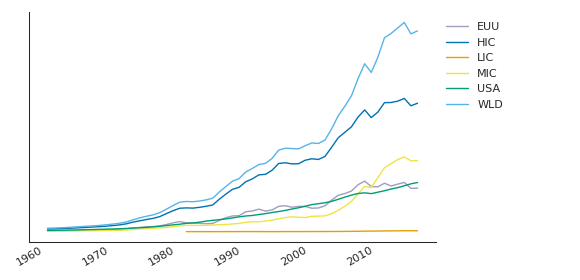
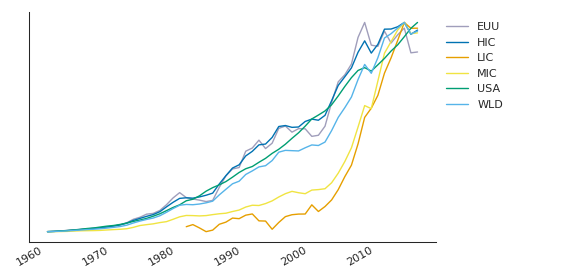
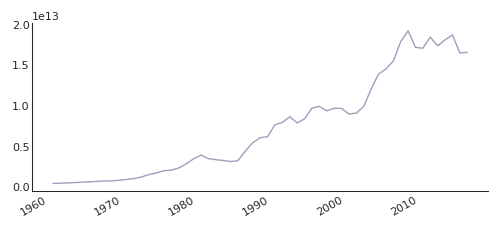
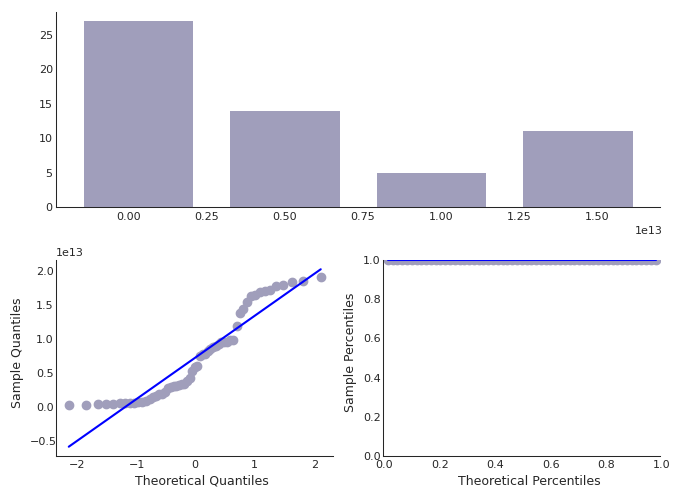
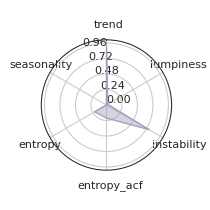
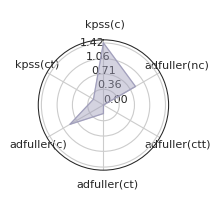
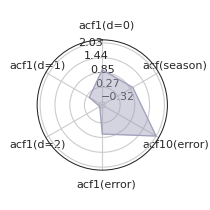
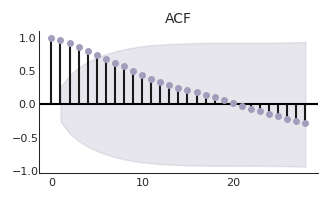
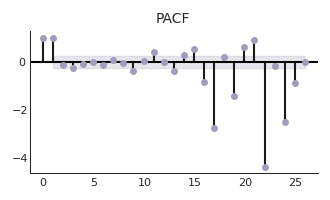
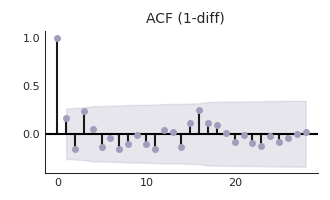
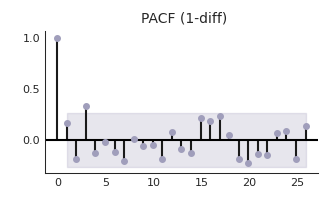
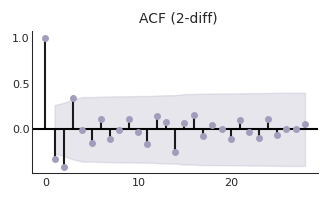
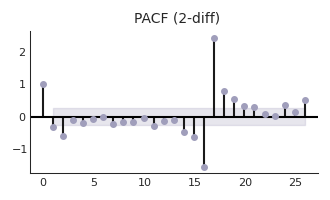
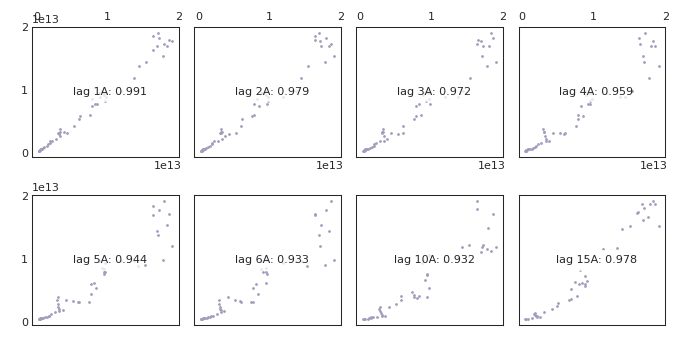
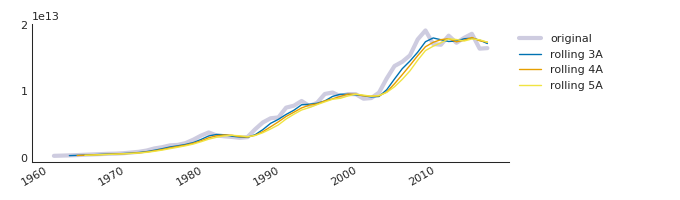
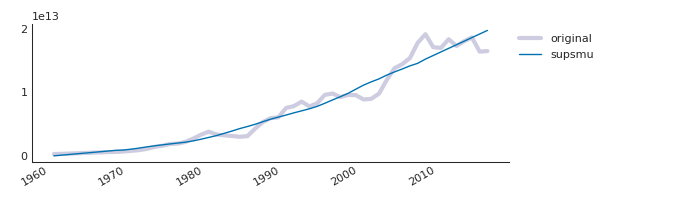
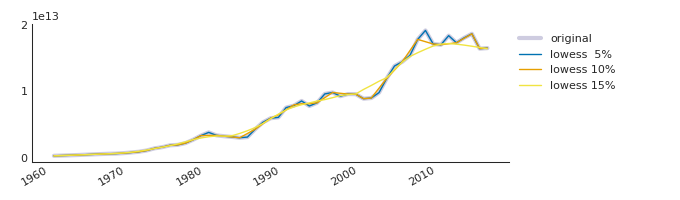
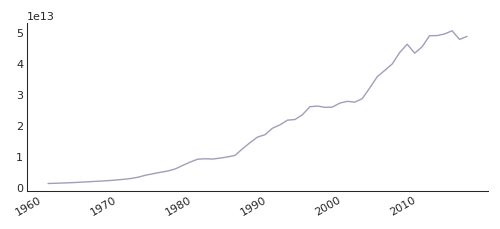
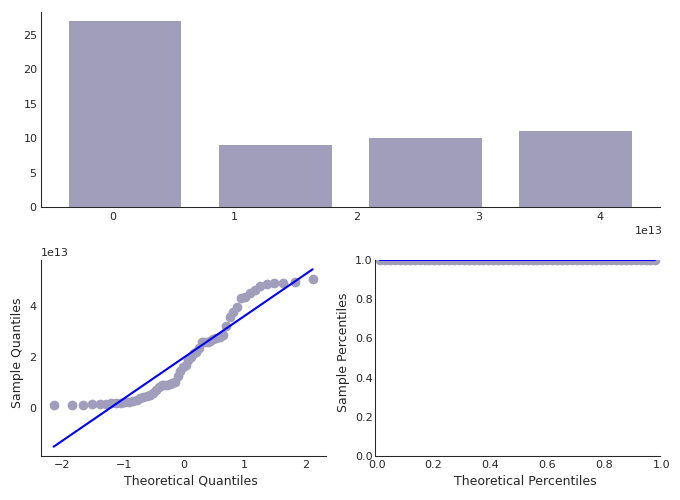
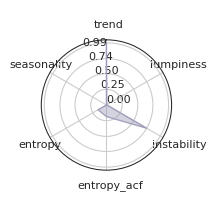
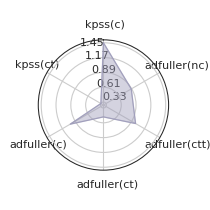
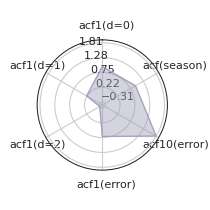
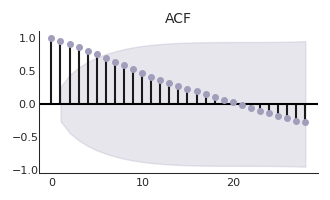
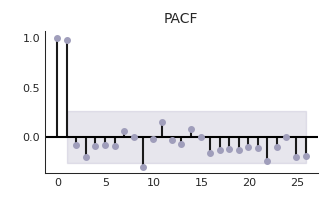
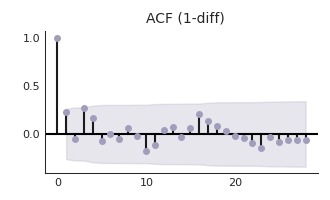
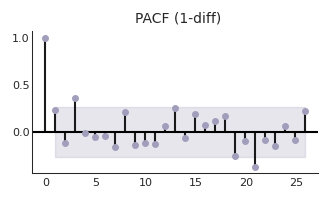
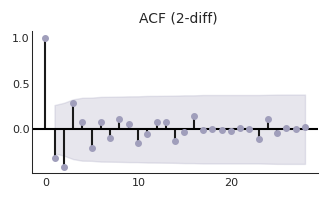
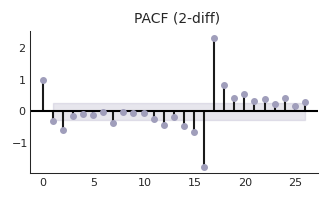
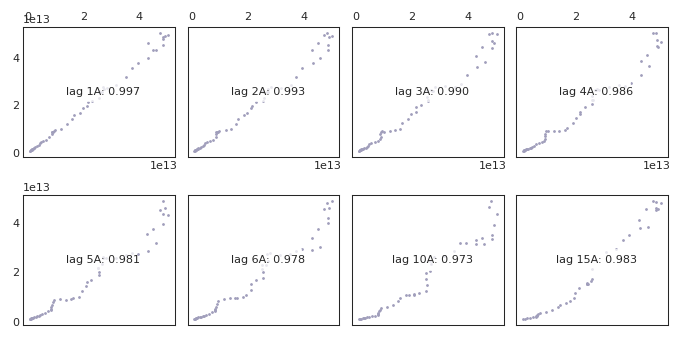
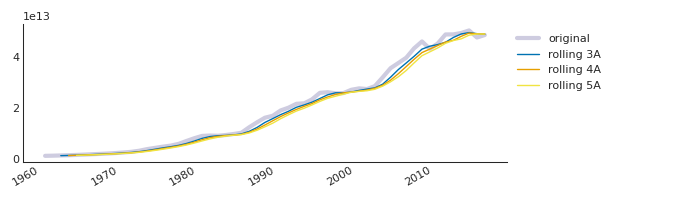
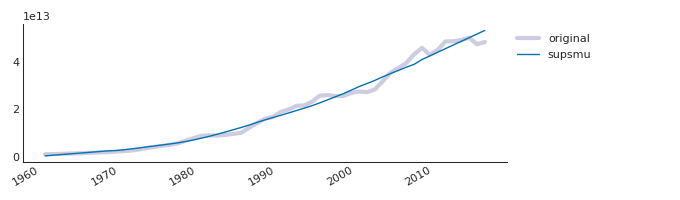
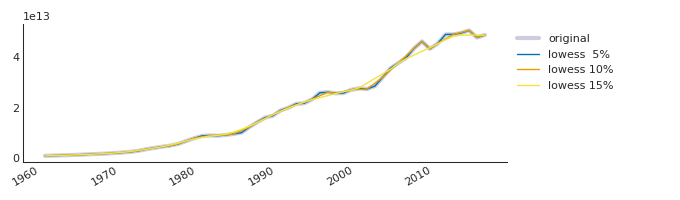
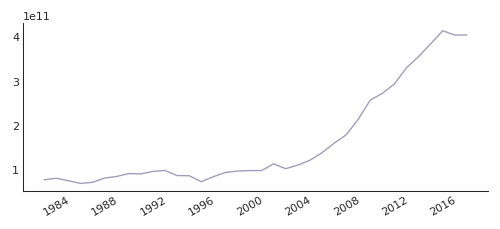
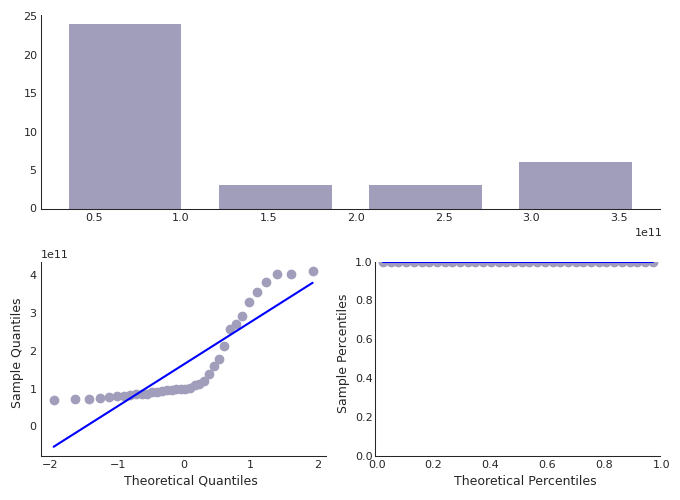
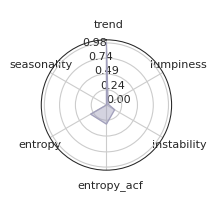
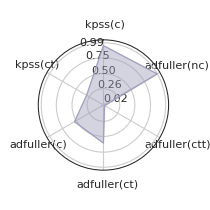
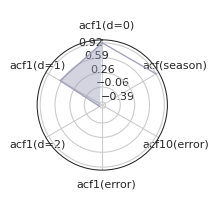
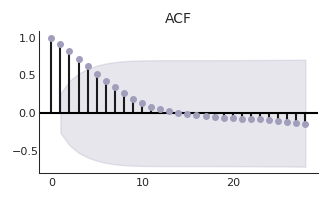
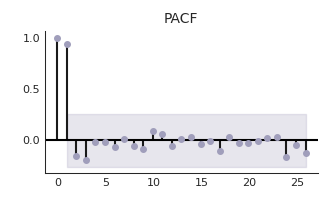
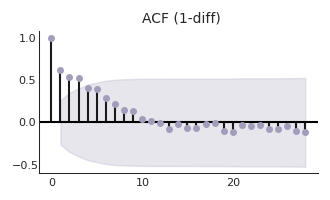
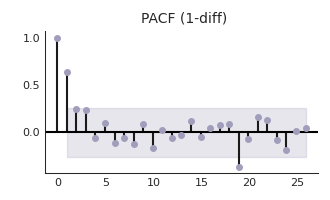
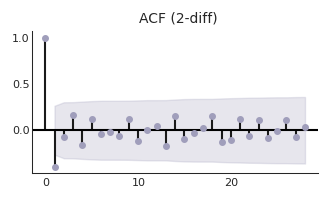
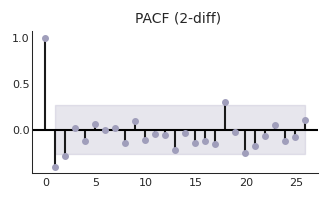
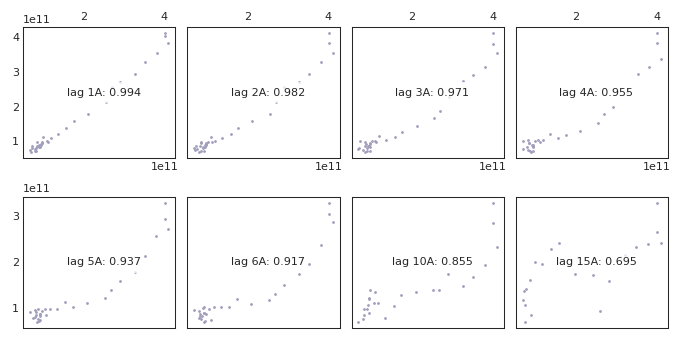
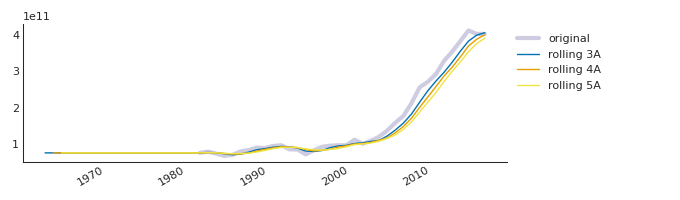
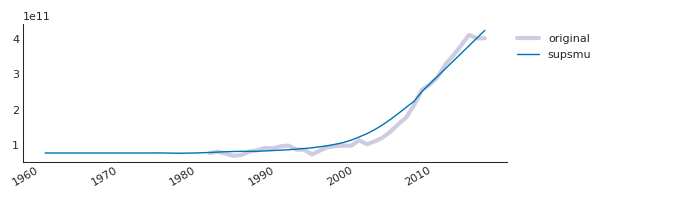
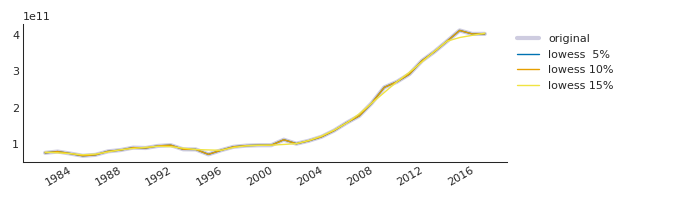
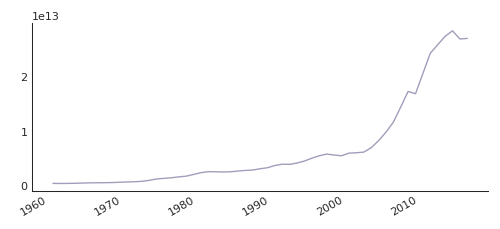
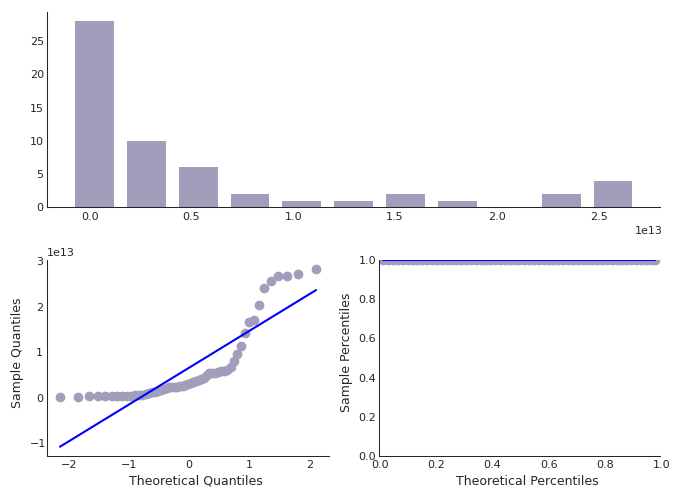
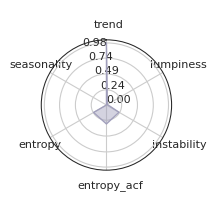
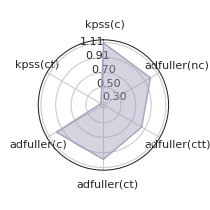
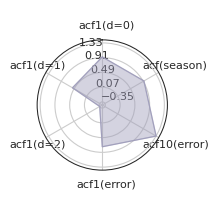
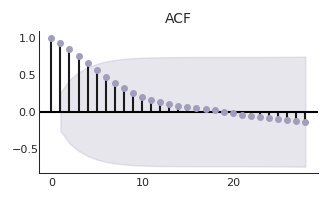
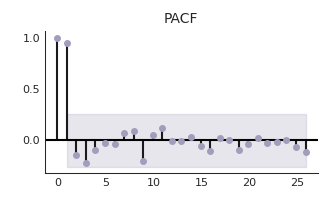
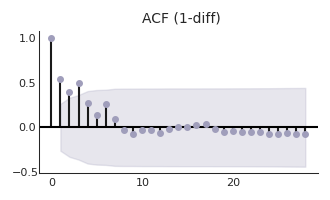
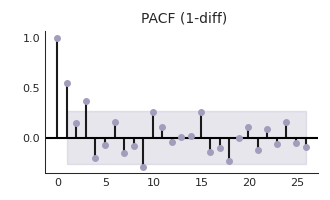
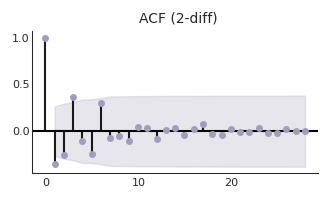
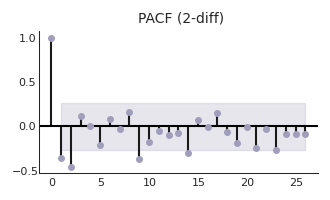
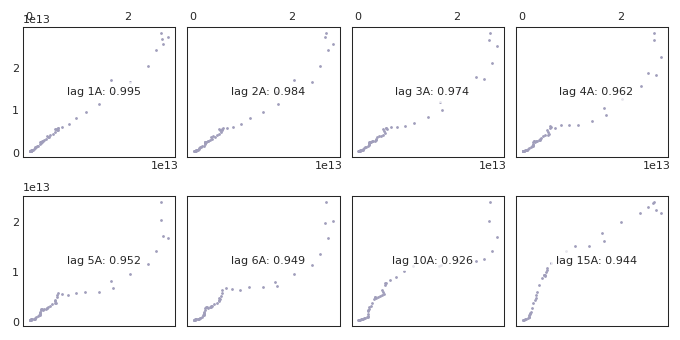
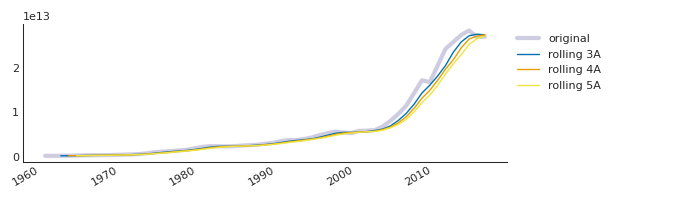
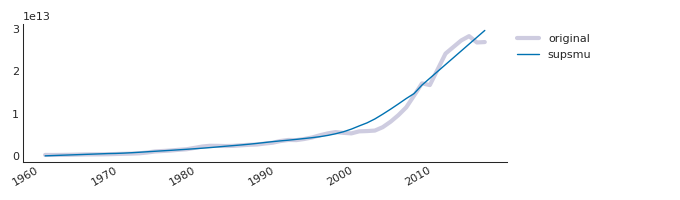
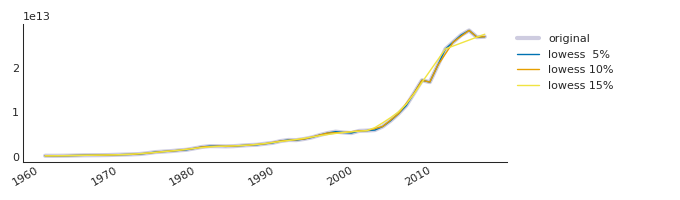
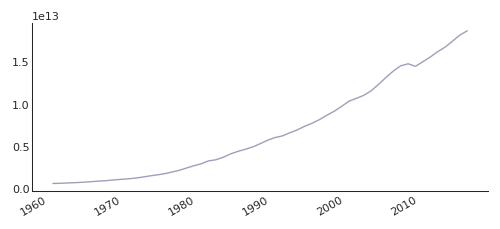
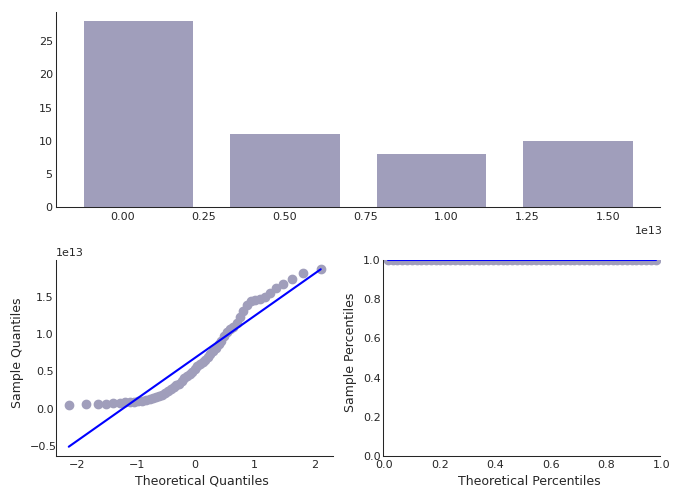
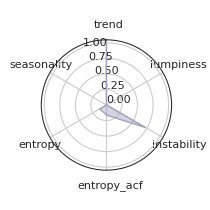
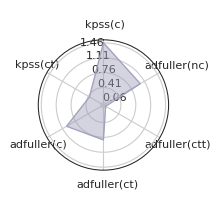
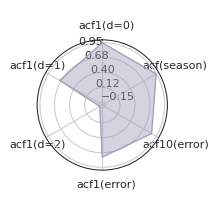
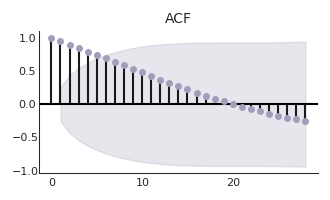
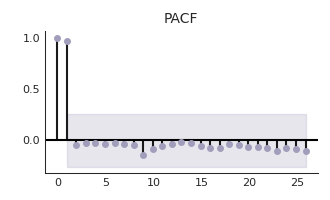
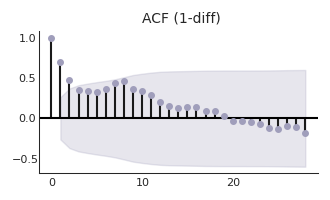
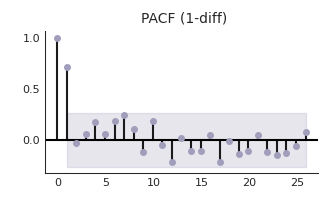
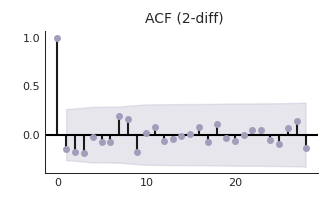
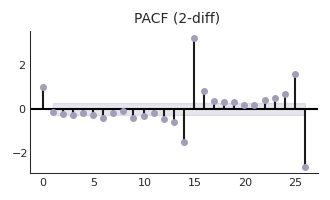
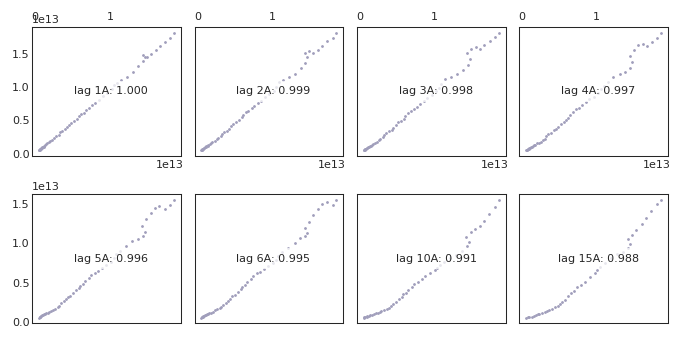
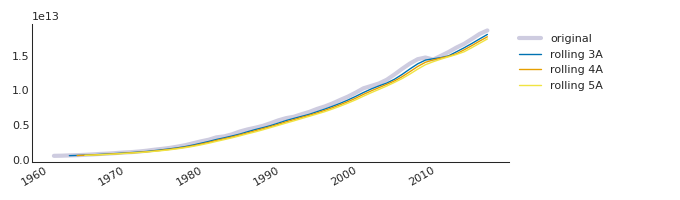
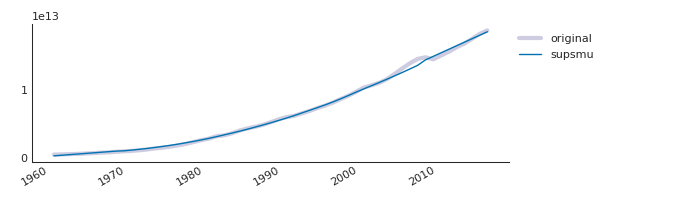
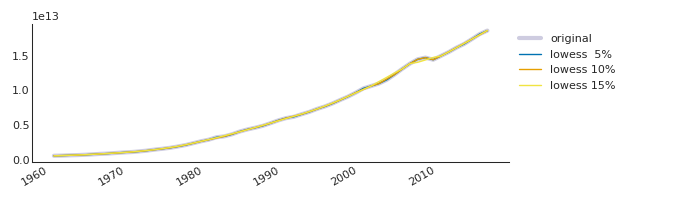
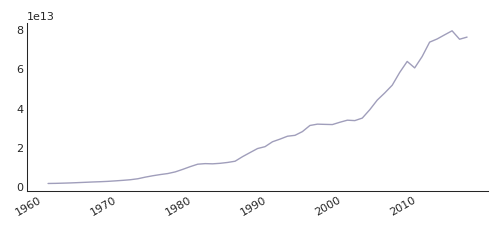
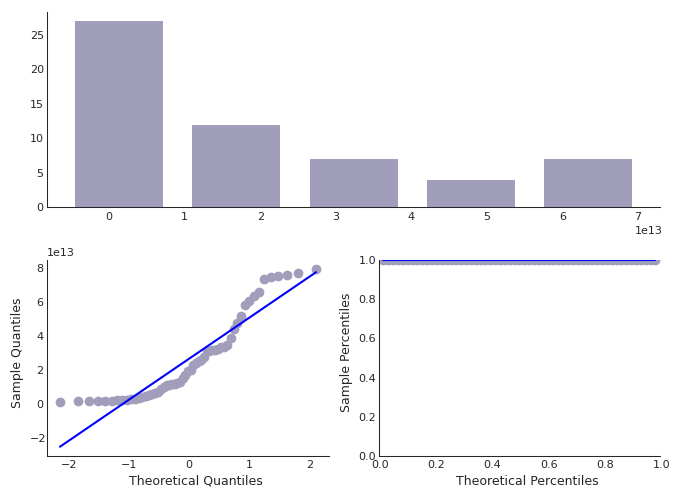
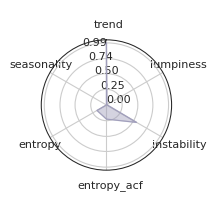
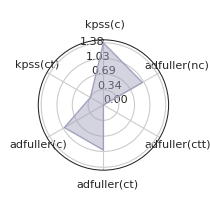
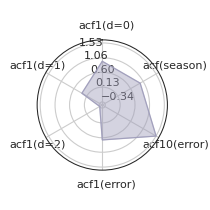
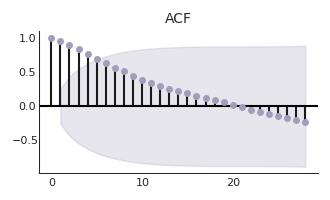
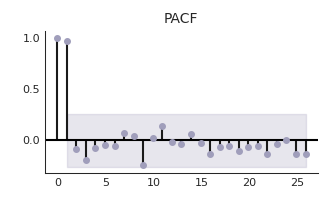
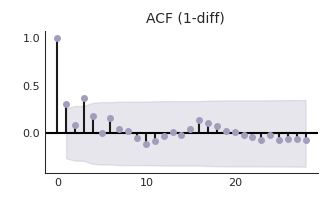
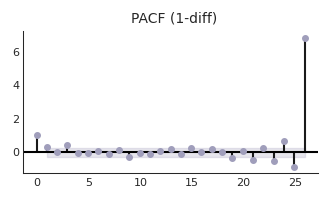
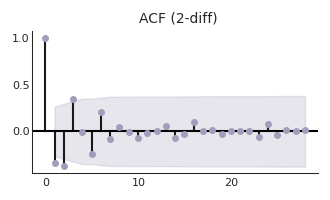
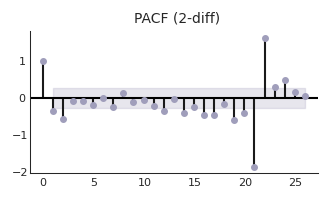
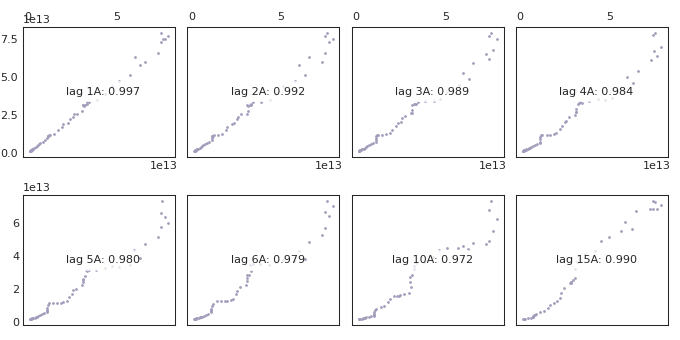
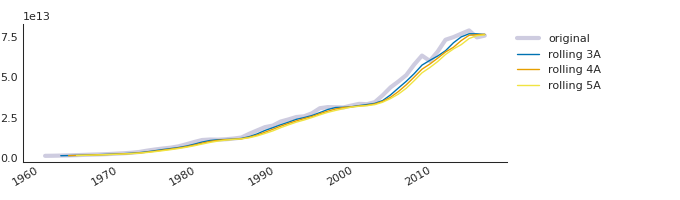
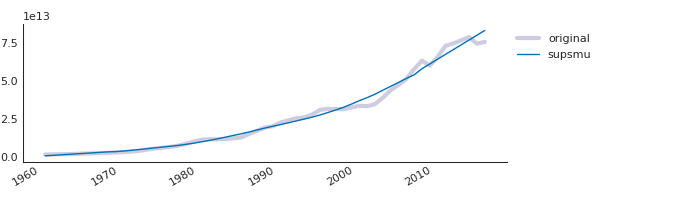
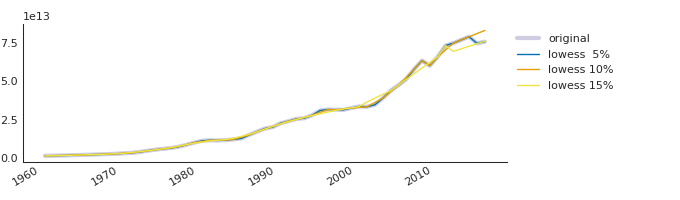
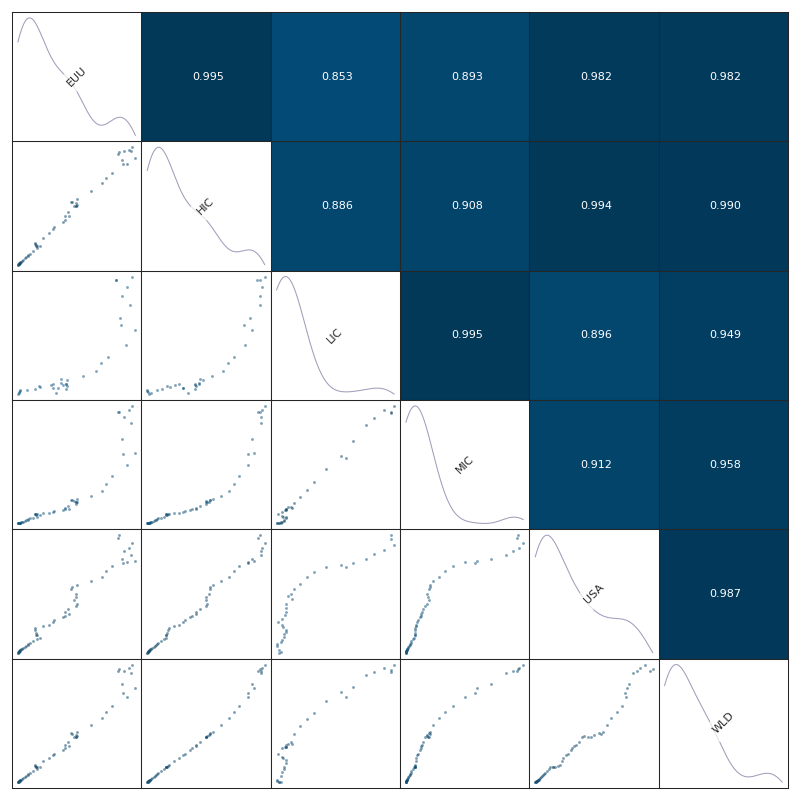
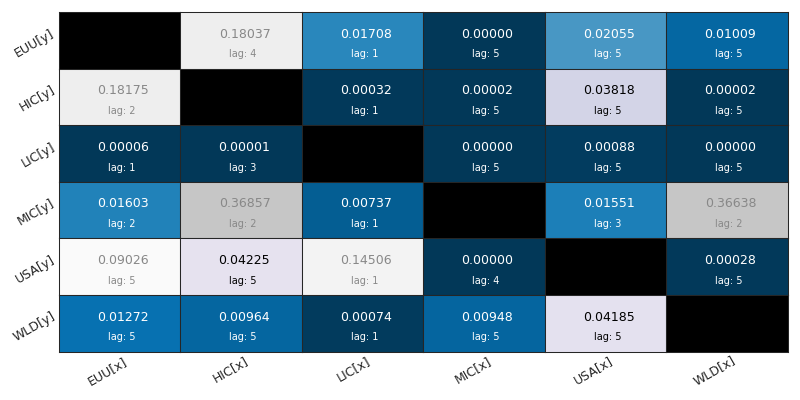
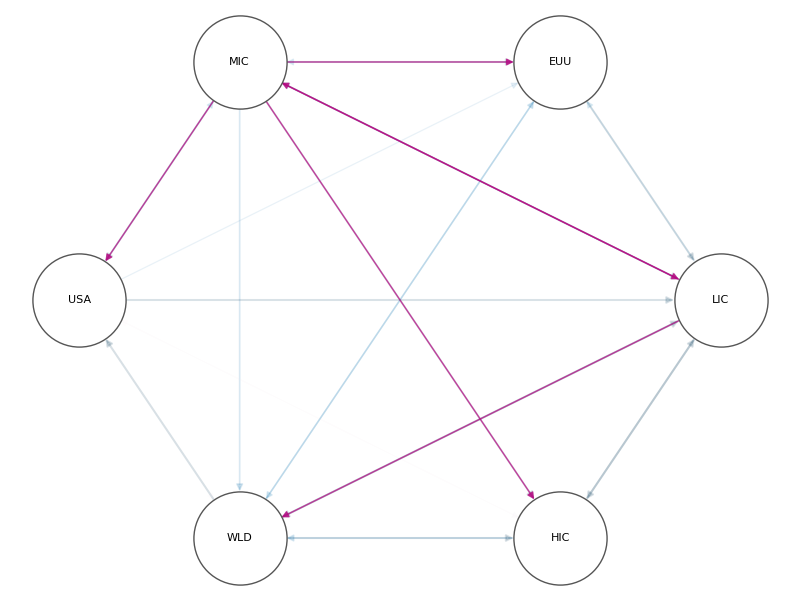

In [9]:
tslumen.HtmlReport(df, result=pr)


## Creating a custom HTML Report

We will now create a custom section and a custom report along with their HTML templates.  
The report will include the new section and 2 of tslumen's default ones, where for one of them we have redefined the template locally (previous chapter).

In [10]:
with open('./templates/html/SectionExecution.html', 'w') as fp:
    fp.write('''\
{% extends "_section.html" %}
{% from '_macros.html' import render_dataframe %}
{% block section_content -%}
{{ render_dataframe('10 slowest profiling function executions', obj.top10) }}
{%- endblock %}''')
    

class SectionExecution(tslumen.report.html.base.HtmlBlock):
    _id = "exec"
    _title = "Execution"

    def __init__(self, result, meta, df, scheduler):
        self.top10 = result.result.exec_details\
            .sort_values('Duration', ascending=False)\
            .reset_index(drop=True).head(10)[['Profiler', 'Scope', 'Target', 'Duration']]

In [11]:
with open('./templates/html/MyReport.html', 'w') as fp:
    fp.write('''\
{% block content -%}
<a class="anchor-pos" id="top"></a>
{%  for section in obj.sections -%}
  {{ section|html }}
{%- endfor %}
{%- endblock content %}''')


class MyReport(tslumen.HtmlReport):
    SECTIONS = [
        tslumen.report.html.sections.SectionTSFeatures,
        tslumen.report.html.sections.SectionRelations,
        SectionExecution,
    ]

Rendering remaining sections:   0%|          | 0/3 [00:00<?, ?it/s]


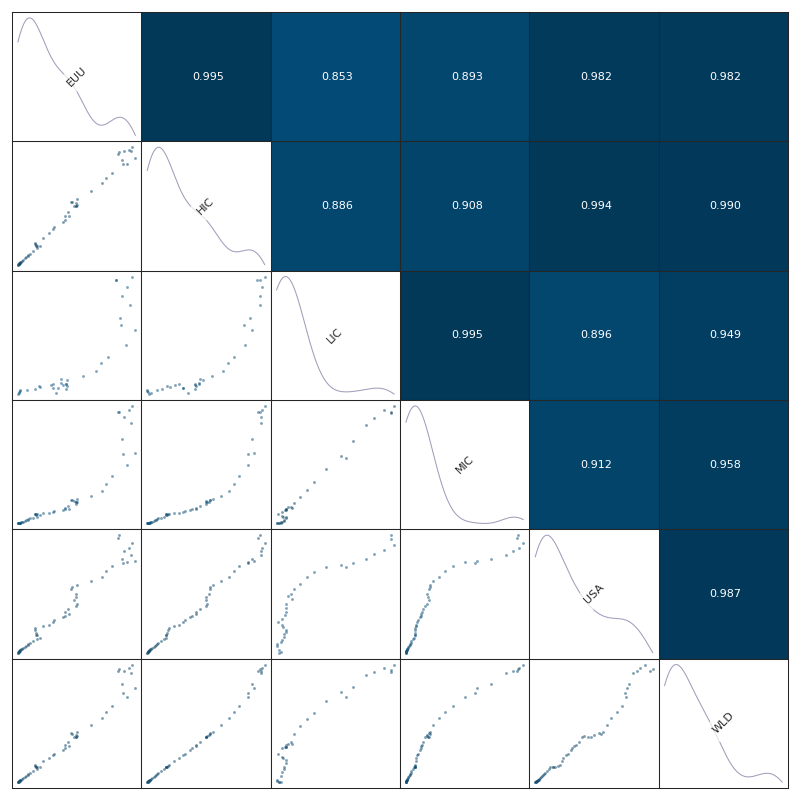
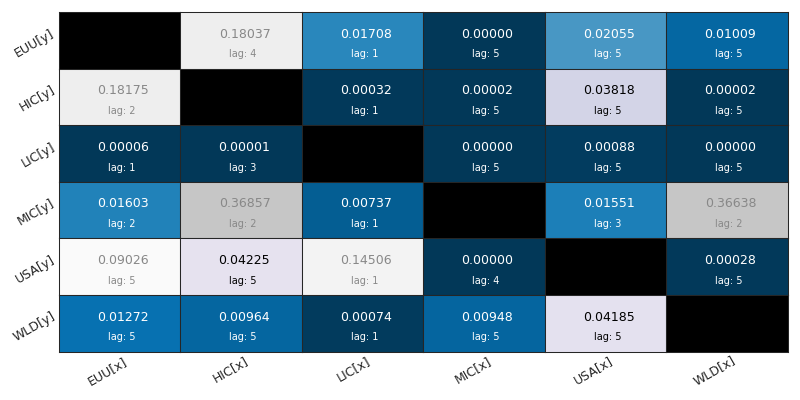
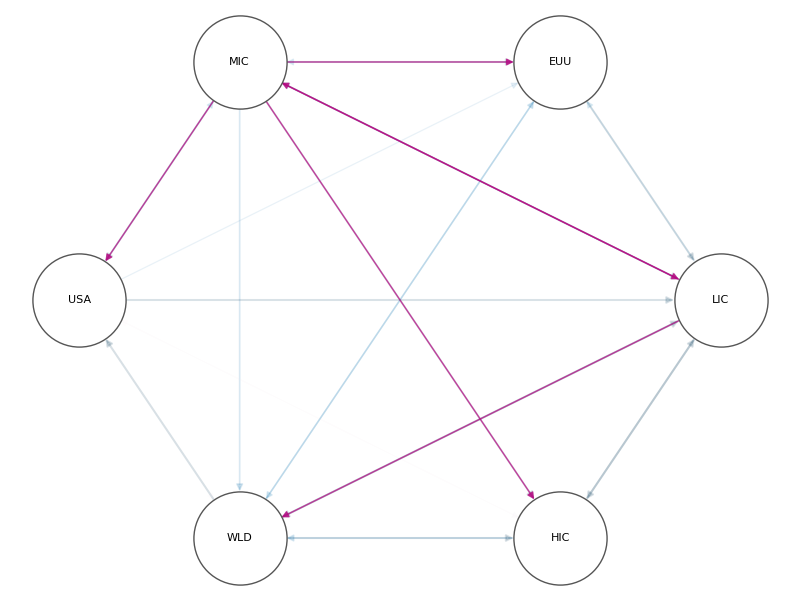

In [12]:
MyReport(df, result=pr)

In [13]:
# cleanup
os.remove('./templates/html/MyReport.html')
os.remove('./templates/html/SectionExecution.html')
os.remove('./templates/html/SectionTSFeatures.html')
os.removedirs('./templates/html')